In [1]:
!pip install torch torchvision scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [2]:
import os
import math
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import random
from pathlib import Path
from shutil import copy2

In [3]:
# Set your dataset path here
data_root = Path("/kaggle/input/kengo-k423/MangoLeafBD Dataset")
output_root = Path("/kaggle/working/fewshot_dataset")
support_dir = output_root / "support"
query_dir = output_root / "query"

# Create folders
for folder in [support_dir, query_dir]:
    folder.mkdir(parents=True, exist_ok=True)

# Get list of classes with enough images
classes = sorted([d.name for d in data_root.iterdir() if d.is_dir()])
eligible_classes = [cls for cls in classes if len(list((data_root / cls).glob("*"))) >= 6]

# Sample 5 classes (5-way)
selected_classes = random.sample(eligible_classes, 5)

fewshot_split = {}
for cls in selected_classes:
    class_path = data_root / cls
    images = sorted([f for f in class_path.glob("*") if f.suffix.lower() in [".jpg", ".jpeg", ".png"]])
    sampled = random.sample(images, 6)  # 1 support, 5 query

    fewshot_split[cls] = {
        "support": sampled[0].name,
        "query": [img.name for img in sampled[1:]]
    }

    # Save support image
    (support_dir / cls).mkdir(parents=True, exist_ok=True)
    copy2(sampled[0], support_dir / cls / sampled[0].name)

    # Save query images
    (query_dir / cls).mkdir(parents=True, exist_ok=True)
    for img in sampled[1:]:
        copy2(img, query_dir / cls / img.name)

# Print the split info
import json
print(json.dumps(fewshot_split, indent=2))

{
  "Healthy": {
    "support": "20211231_160908 (Custom).jpg",
    "query": [
      "20211231_125015 (Custom).jpg",
      "20211231_160709 (Custom).jpg",
      "20211231_155835 (Custom).jpg",
      "20211231_161857 (Custom).jpg",
      "20211231_124712 (Custom).jpg"
    ]
  },
  "Cutting Weevil": {
    "support": "20211011_160853 (Custom).jpg",
    "query": [
      "20211011_161505 (Custom) (Custom).jpg",
      "20211011_161145(0) (Custom) (Custom).jpg",
      "20211011_161135 (Custom) (Custom).jpg",
      "20211011_161956 (Custom).jpg",
      "20211011_161605 (Custom).jpg"
    ]
  },
  "Powdery Mildew": {
    "support": "IMG_20211107_124440 (Custom).jpg",
    "query": [
      "IMG_20211107_122456 (Custom).jpg",
      "IMG_20211107_125656 (Custom).jpg",
      "20211109_122028 (Custom).jpg",
      "IMG_20211107_123856 (Custom).jpg",
      "IMG_20211107_125925 (Custom).jpg"
    ]
  },
  "Gall Midge": {
    "support": "IMG_20211106_163300 (Custom).jpg",
    "query": [
      "IMG_20211106

In [4]:
# === Dataset ===
data_path = "/kaggle/input/kengo-k423/MangoLeafBD Dataset"
classes = sorted(os.listdir(data_path))

def create_splits(path, test_size=0.3, seed=42):
    image_paths, labels = [], []
    for label, class_name in enumerate(classes):
        class_path = os.path.join(path, class_name)
        for img_name in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img_name))
            labels.append(label)
    return image_paths, labels

X_all, y_all = create_splits(data_path)

# === AMDIM-style Transform (Improved) ===
class AMDIMTransform:
    def __init__(self):
        self.global_crop = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.3, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4, 0.4, 0.2, 0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.669, 0.691, 0.685],
                                std = [0.203, 0.193, 0.264])
        ])
        self.local_crop = transforms.Compose([
            transforms.RandomResizedCrop(96, scale=(0.3, 0.6)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.2, 0.2, 0.1, 0.05),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.669, 0.691, 0.685],
                                std = [0.203, 0.193, 0.264])
        ])

    def __call__(self, img):
        return self.global_crop(img), self.local_crop(img)

# === AMDIM Dataset ===
class AMDIMDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(img)

# === Mutual Info Loss ===
class InfoNCELoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, z_global, z_local):
        batch_size = z_global.size(0)
        z_global = F.normalize(z_global, dim=1)
        z_local = F.normalize(z_local, dim=1)
        logits = torch.mm(z_global, z_local.t()) / self.temperature
        labels = torch.arange(batch_size).to(z_global.device)
        return F.cross_entropy(logits, labels)

# === AMDIM Model with Stronger Projection ===
class AMDIM(nn.Module):
    def __init__(self, global_encoder, local_encoder):
        super().__init__()
        self.global_encoder = global_encoder
        self.local_encoder = local_encoder
        self.global_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128)
        )
        self.local_head = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128)
        )

    def forward(self, global_x, local_x):
        g_feat = self.global_encoder(global_x).view(global_x.size(0), -1)
        l_feat = self.local_encoder(local_x).view(local_x.size(0), -1)
        g_out = self.global_head(g_feat)
        l_out = self.local_head(l_feat)
        return g_out, l_out

# === Init Model ===
resnet_global = models.resnet50(weights=None)
resnet_local = models.resnet18(weights=None)
backbone_g = nn.Sequential(*list(resnet_global.children())[:-1])
backbone_l = nn.Sequential(*list(resnet_local.children())[:-1])
model = AMDIM(backbone_g, backbone_l).cuda()

transform = AMDIMTransform()
dataset = AMDIMDataset(X_all, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2, drop_last=True)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(dataloader) * 50)
criterion = InfoNCELoss()

# === Train AMDIM ===
def train_amdim(model, dataloader, optimizer, scheduler, criterion, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for global_x, local_x in dataloader:
            global_x, local_x = global_x.cuda(), local_x.cuda()
            g_out, l_out = model(global_x, local_x)
            loss = criterion(g_out, l_out)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Avg Loss: {total_loss/len(dataloader):.4f}")

train_amdim(model, dataloader, optimizer, scheduler, criterion, epochs=50)

# mango
# Dataset Mean (RGB): [0.669, 0.691, 0.685]
# Dataset Std (RGB): [0.203, 0.193, 0.264]

Epoch 1/50 - Avg Loss: 3.2190
Epoch 2/50 - Avg Loss: 2.3464
Epoch 3/50 - Avg Loss: 1.8891
Epoch 4/50 - Avg Loss: 1.6614
Epoch 5/50 - Avg Loss: 1.4564
Epoch 6/50 - Avg Loss: 1.3188
Epoch 7/50 - Avg Loss: 1.2308
Epoch 8/50 - Avg Loss: 1.1328
Epoch 9/50 - Avg Loss: 1.0803
Epoch 10/50 - Avg Loss: 1.0083
Epoch 11/50 - Avg Loss: 0.9447
Epoch 12/50 - Avg Loss: 0.9132
Epoch 13/50 - Avg Loss: 0.8621
Epoch 14/50 - Avg Loss: 0.8207
Epoch 15/50 - Avg Loss: 0.7719
Epoch 16/50 - Avg Loss: 0.8026
Epoch 17/50 - Avg Loss: 0.7399
Epoch 18/50 - Avg Loss: 0.6960
Epoch 19/50 - Avg Loss: 0.6811
Epoch 20/50 - Avg Loss: 0.6885
Epoch 21/50 - Avg Loss: 0.6626
Epoch 22/50 - Avg Loss: 0.5907
Epoch 23/50 - Avg Loss: 0.5714
Epoch 24/50 - Avg Loss: 0.5700
Epoch 25/50 - Avg Loss: 0.5458
Epoch 26/50 - Avg Loss: 0.5090
Epoch 27/50 - Avg Loss: 0.5020
Epoch 28/50 - Avg Loss: 0.5115
Epoch 29/50 - Avg Loss: 0.4536
Epoch 30/50 - Avg Loss: 0.4202
Epoch 31/50 - Avg Loss: 0.4205
Epoch 32/50 - Avg Loss: 0.4315
Epoch 33/50 - Avg

In [5]:
from pathlib import Path
import random
from shutil import copy2

src_dir = Path("/kaggle/input/kengo-k423/MangoLeafBD Dataset")
support_dir = Path("/kaggle/working/fewshot_dataset/support")
query_dir = Path("/kaggle/working/fewshot_dataset/query")

support_dir.mkdir(parents=True, exist_ok=True)
query_dir.mkdir(parents=True, exist_ok=True)

# Pick 5 classes with enough images (≥10 images per class recommended)
classes = sorted([cls.name for cls in src_dir.iterdir() if cls.is_dir() and len(list(cls.glob("*"))) >= 20])
selected_classes = random.sample(classes, 5)

fewshot_split = {}

for cls in selected_classes:
    images = list((src_dir / cls).glob("*"))
    selected_imgs = random.sample(images, 20)  # 5 for support, 15 for query

    # Save support
    (support_dir / cls).mkdir(parents=True, exist_ok=True)
    for img in selected_imgs[:5]:
        copy2(img, support_dir / cls / img.name)

    # Save query
    (query_dir / cls).mkdir(parents=True, exist_ok=True)
    for img in selected_imgs[5:]:
        copy2(img, query_dir / cls / img.name)

    fewshot_split[cls] = {
        "support": [img.name for img in selected_imgs[:5]],
        "query": [img.name for img in selected_imgs[5:]]
    }

import json
print(json.dumps(fewshot_split, indent=2))

{
  "Cutting Weevil": {
    "support": [
      "20211011_161954 (Custom) (Custom).jpg",
      "20211011_161142 (Custom).jpg",
      "20211011_160612 (Custom) (Custom).jpg",
      "20211011_162530 (Custom) (Custom).jpg",
      "20211011_162009 (Custom) (Custom).jpg"
    ],
    "query": [
      "20211011_162048 (Custom) (Custom).jpg",
      "20211011_161610(0) (Custom).jpg",
      "20211011_161657(0) (Custom) (Custom).jpg",
      "20211011_162523(0) (Custom) (Custom).jpg",
      "20211011_161913 (Custom) (Custom).jpg",
      "20211011_162130 (Custom) (Custom).jpg",
      "20211011_161641(0) (Custom).jpg",
      "20211011_162432 (Custom) (Custom).jpg",
      "20211011_161242 (Custom) (Custom).jpg",
      "20211011_161244 (Custom) (Custom).jpg",
      "20211011_131115 (Custom).jpg",
      "20211011_162121 (Custom) (Custom).jpg",
      "20211011_162434 (Custom).jpg",
      "20211011_162404 (Custom) (Custom).jpg",
      "20211011_162026(0) (Custom).jpg"
    ]
  },
  "Anthracnose": {
    "sup

In [6]:
from pathlib import Path
import random
from shutil import copy2

src_dir = Path("/kaggle/input/kengo-k423/MangoLeafBD Dataset")
support_dir = Path("/kaggle/working/fewshot_dataset/support")
query_dir = Path("/kaggle/working/fewshot_dataset/query")

support_dir.mkdir(parents=True, exist_ok=True)
query_dir.mkdir(parents=True, exist_ok=True)

# Pick 5 classes with enough images (≥10 images per class recommended)
classes = sorted([cls.name for cls in src_dir.iterdir() if cls.is_dir() and len(list(cls.glob("*"))) >= 20])
selected_classes = random.sample(classes, 5)

fewshot_split = {}

for cls in selected_classes:
    images = list((src_dir / cls).glob("*"))
    selected_imgs = random.sample(images, 20)  # 5 for support, 15 for query

    # Save support
    (support_dir / cls).mkdir(parents=True, exist_ok=True)
    for img in selected_imgs[:5]:
        copy2(img, support_dir / cls / img.name)

    # Save query
    (query_dir / cls).mkdir(parents=True, exist_ok=True)
    for img in selected_imgs[5:]:
        copy2(img, query_dir / cls / img.name)

    fewshot_split[cls] = {
        "support": [img.name for img in selected_imgs[:5]],
        "query": [img.name for img in selected_imgs[5:]]
    }

import json
print(json.dumps(fewshot_split, indent=2))

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
from PIL import Image
import torch

# === Few-Shot Dataset Class ===
class FewShotDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)), transforms.ToTensor(),
            transforms.Normalize(mean=[0.669, 0.691, 0.685],
                                std = [0.203, 0.193, 0.264])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(img), self.labels[idx]

# === Helper: Extract image paths and numeric labels from folder ===
def get_fewshot_image_paths(base_dir):
    paths, labels, label_map = [], [], {}
    base_dir = Path(base_dir)
    for idx, class_dir in enumerate(sorted(base_dir.iterdir())):
        if class_dir.is_dir():
            label_map[idx] = class_dir.name
            for img_path in class_dir.glob("*"):
                paths.append(str(img_path))
                labels.append(idx)
    return paths, labels, label_map

# === Helper: Feature extraction ===
def extract_features(encoder, dataloader):
    encoder.eval()
    feats, lbls = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.cuda()
            feat = encoder(x).view(x.size(0), -1)
            feats.append(feat.cpu())
            lbls.append(y)
    return torch.cat(feats), torch.cat(lbls)

# === Load Few-Shot Datasets ===
support_paths, support_labels, label_map = get_fewshot_image_paths("/kaggle/working/fewshot_dataset/support")
query_paths, query_labels, _ = get_fewshot_image_paths("/kaggle/working/fewshot_dataset/query")

support_loader = DataLoader(FewShotDataset(support_paths, support_labels), batch_size=32)
query_loader = DataLoader(FewShotDataset(query_paths, query_labels), batch_size=32)

# === Extract Features from Ajisai's Global Encoder ===
encoder = model.global_encoder.cuda()
X_support, y_support = extract_features(encoder, support_loader)
X_query, y_query = extract_features(encoder, query_loader)

# === Train + Evaluate Logistic Regression ===
clf = LogisticRegression(max_iter=5000)
clf.fit(X_support, y_support)
y_pred = clf.predict(X_query)

# === Report Metrics ===
acc = accuracy_score(y_query, y_pred)
precision = precision_score(y_query, y_pred, average='macro', zero_division=0)
recall = recall_score(y_query, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_query, y_pred, average='macro', zero_division=0)

print("\n🔍 Few-Shot Evaluation Results")
print(f"Accuracy      : {acc:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"Class Mapping : {label_map}")

{
  "Powdery Mildew": {
    "support": [
      "20211109_121723 (Custom).jpg",
      "IMG_20211107_125152 (Custom).jpg",
      "IMG_20211107_124431 (Custom).jpg",
      "20211109_122030 (Custom).jpg",
      "IMG_20211107_125018 (Custom).jpg"
    ],
    "query": [
      "20211109_122259 (Custom).jpg",
      "20211109_122037 (Custom).jpg",
      "IMG_20211107_124631 (Custom).jpg",
      "20211109_121757 (Custom).jpg",
      "IMG_20211107_115458 (Custom).jpg",
      "IMG_20211107_125938 (Custom).jpg",
      "IMG_20211107_124933 (Custom).jpg",
      "IMG_20211107_143723 (Custom).jpg",
      "IMG_20211107_121423 (Custom).jpg",
      "IMG_20211107_124638 (Custom).jpg",
      "20211109_122307 (Custom).jpg",
      "IMG_20211107_124031 (Custom).jpg",
      "20211109_121419 (Custom).jpg",
      "IMG_20211107_125747 (Custom).jpg",
      "IMG_20211107_125336 (Custom).jpg"
    ]
  },
  "Healthy": {
    "support": [
      "20211231_124733 (Custom).jpg",
      "20211231_125350 (Custom).jpg",
      "2

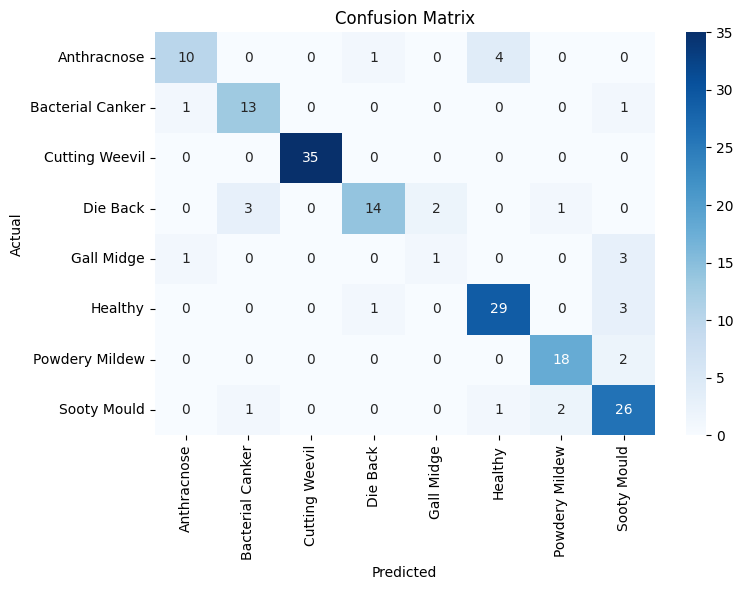

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# === Confusion Matrix ===
cm = confusion_matrix(y_query, y_pred)
class_names = [label_map[i] for i in sorted(label_map.keys())]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()